# Exploratory Data Analysis of news articles dataset
Contributions: EDA conducted by Shaun, Samson and Yu Xiang, dataset compiled by news articles data scraping team

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

import string
import re
import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from dateutil import parser

In [2]:
df = pd.read_csv('news_articles_cleanedv5.csv')
df.head()

title  \
0  'It took months to see the end of the tunnel':...   
1  'Everyone watching makes me feel uneasy': Stud...   
2  Singapore Mental Health Film Festival 2021 ret...   
3  Woman, 19, rescued after sitting on 27th-floor...   
4  'I wanted to push the aircon out and jump down...   

                                                 url tags        date  \
0  https://www.asiaone.com/lifestyle/it-took-mont...  NIL  05/06/2021   
1  https://www.asiaone.com/singapore/everyone-wat...  NIL  01/06/2021   
2  https://www.asiaone.com/lifestyle/singapore-me...  NIL  18/05/2021   
3  https://www.asiaone.com/singapore/woman-19-res...  NIL  09/04/2021   
4  https://www.asiaone.com/lifestyle/i-wanted-pus...  NIL  09/01/2021   

                                             content  covid news_source  
0  When she first started gymnastics at the age o...  False    Asia One  
1  These days, Natasha Osman would sit in front o...  False    Asia One  
2  The Covid-19 pandemic has heightened concerns ...   True    Asia One  
3  Residents in Sengkang craned their necks as th...  False    Asia One  
4  In his 30s and at the peak of his life and car...  False    Asia One

## Data cleaning
(contributed by Shaun and Yu Xiang)

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y') #datetime conversion

In [4]:
# Removing URLs, non-alphabets, stopwords (incld custom ones) + lemmatise words

nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk_stopwords.extend(['á', "s","â","singapore","singaporean","sâ", "will", "said","one", 'could', 'would', 'may', 'also', 'say', 'like'])

def text_processor(text):
    # Remove HTML Tags
    try:
        text = html.document_fromstring(text).text_content()
    except:
        pass

    text = text.lower() #lower case
    text = re.sub(r'http\S+', '', text) #remove urls
    text = re.sub('[^a-zA-Z ]+', ' ', text) #remove non-alphabets
    # text = "".join([i for i in text if i not in string.punctuation]) #remove punctuations
    tokens  = re.split(' ', text) #split str into list
    tokens = [t for t in tokens if (t not in nltk_stopwords) and (len(t) > 2)] #remove stopwords and words less than 3 letters

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatised = [wordnet_lemmatizer.lemmatize(word) for word in tokens] #lemmatise

    output = " ".join(word for word in lemmatised)

    return output

df['cleaned_content'] = df['content'].apply(text_processor)

In [5]:
# Example of before/after (first article):
print(df['content'][0][:200])
print("")
print(df['cleaned_content'][0][:200])

When she first started gymnastics at the age of eight, Joy Koh recalls being mesmerised by cartwheels and splits. But she was soon hit with a reality check. Subscribing to the "no pain, no gain" minds

first started gymnastics age eight joy koh recall mesmerised cartwheel split soon hit reality check subscribing pain gain mindset coach body shame push beyond limit year old tell asiaone child cry puk


## Basic EDA
(contributed by Shaun, Yu Xiang and Samson)

Total number of articles: 977.
Covid-related: 736; non-covid-related: 241
Date range of articles: 2018-03-30 to 2021-07-12
Type of news source: ['Asia One' 'Mothership' 'Nikkei Asia' 'Stress & Health' 'The Economist'
 'HRD' 'BioSpectrum' 'deccanherald' 'Human Resource Online' 'Dovepress'
 'CTV News' 'Nature' 'NDTV' 'Wired' 'Asia Insurance' 'Talter' 'KrAsia'
 'The 47' 'Insurance Business' 'TNP SG' 'Rice Media' 'Straits Times' 'CNA'
 'Today Online']


Text(0.5, 1.0, 'Distribution of news articles')

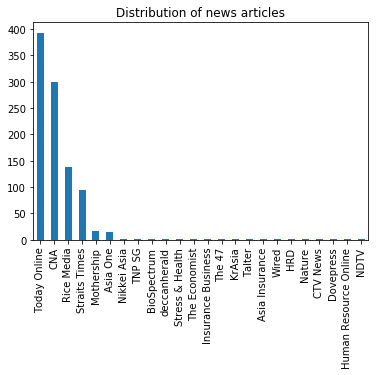

In [6]:
# Basic EDA + Distribution of news articles, by source
print("Total number of articles: {}.\nCovid-related: {}; non-covid-related: {}".format(len(df), sum(df['covid']), len(df)-sum(df['covid'])))
print("Date range of articles: {} to {}".format(str(min(df['date']))[:10], str(max(df['date']))[:10]))
print("Type of news source: {}".format(df.news_source.unique()))

ax = df['news_source'].value_counts().plot(kind='bar')
ax.set_title('Distribution of news articles')

Text(0.5, 1.0, 'Monthly count of news articles')

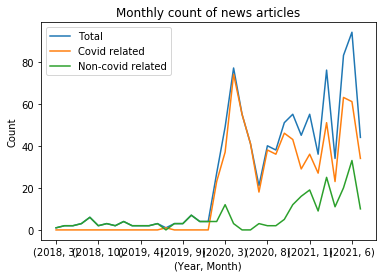

In [7]:
# Count of news articles over time, split by covid-related and otherwise
count_date_all = df['date'].groupby([df.date.dt.year, df.date.dt.month]).agg('count') #df containing monthly count of articles
count_date_covid = df[df['covid']]['date'].groupby([df.date.dt.year, df.date.dt.month]).agg('count')
count_date_non_covid =df[~df['covid']]['date'].groupby([df.date.dt.year, df.date.dt.month]).agg('count')

count_df = pd.concat([count_date_all,count_date_covid, count_date_non_covid], axis=1)
count_df.columns = ['Total','Covid related','Non-covid related']
count_df.replace(np.NaN, 0, inplace=True)

ax = count_df.plot(kind='line')
ax.set_ylabel('Count')
ax.set_xlabel('(Year, Month)')
ax.set_title('Monthly count of news articles')

# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     print(n,label)

In [16]:
kws = ['depression', 'mental illness', 'unalive' , 'social anxiety', 'loneliness',
'stress', 'lonely', 'isolation', 'suicide', 'abuse', 'death', 'post traumatic stress disorder',
'no motivation', 'therapy', 'trauma', 'counselling', 'mood disorder', 'mood swings',
'mental health', 'angst', 'emotion', 'phobia', 'addiction', 'stigma', 'self-harm',
'neurosis', 'disorder', 'dependence', 'socialize', 'help', 'dead', 'melancholia',
'dysthemia', 'tired', 'trapped', 'paranoia', 'overwhelmed', 'irritable', 'bipolar', 'psychologist', 'well-being',
'imh', 'sos', 'counsellor', 'toxic', 'insominia', 'drugs', 'fight','self-esteem']

#counting number of articles/titles containing keyword (+1 if appear in article at least once)
def kws_count(df_series, kws):
    data = {}
    for article in df_series:
        for kw in kws:
            if kw not in data:
                data[kw] = 0
            if kw in article.lower():
                data[kw] += 1

    print(data)

    df_count = pd.DataFrame(data.items(), columns = ["keywords","count"])
    df_count = df_count.sort_values("count",ascending = False)
    return df_count

print('Number of articles containing keyword')
kw_count_in_content_df = kws_count(df['content'], kws) 
print("")
print('Number of article titles containing keyword')
kw_count_in_title_df = kws_count(df['title'], kws)

Number of articles containing keyword
{'depression': 149, 'mental illness': 72, 'unalive': 0, 'social anxiety': 5, 'loneliness': 44, 'stress': 406, 'lonely': 31, 'isolation': 133, 'suicide': 114, 'abuse': 149, 'death': 175, 'post traumatic stress disorder': 1, 'no motivation': 1, 'therapy': 104, 'trauma': 59, 'counselling': 159, 'mood disorder': 8, 'mood swings': 9, 'mental health': 499, 'angst': 11, 'emotion': 234, 'phobia': 36, 'addiction': 30, 'stigma': 127, 'self-harm': 34, 'neurosis': 0, 'disorder': 147, 'dependence': 39, 'socialize': 0, 'help': 690, 'dead': 77, 'melancholia': 0, 'dysthemia': 0, 'tired': 78, 'trapped': 32, 'paranoia': 11, 'overwhelmed': 46, 'irritable': 3, 'bipolar': 34, 'psychologist': 122, 'well-being': 199, 'imh': 97, 'sos': 47, 'counsellor': 89, 'toxic': 56, 'insominia': 0, 'drugs': 35, 'fight': 116, 'self-esteem': 12}

Number of article titles containing keyword
{'depression': 2, 'mental illness': 6, 'unalive': 0, 'social anxiety': 0, 'loneliness': 2, 'stress

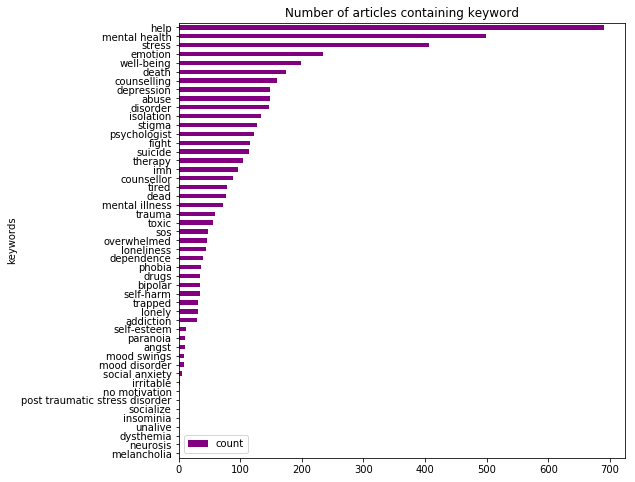

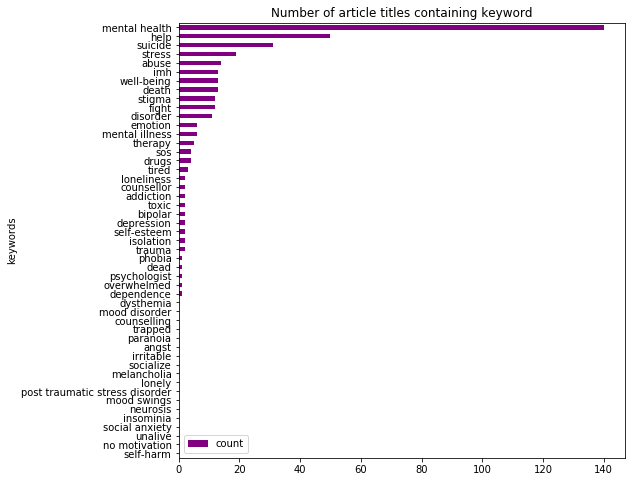

In [62]:
#plot horizontal bar graph of keyword counts
def kws_graph(kw_count_df, title):
    fig, ax = plt.subplots(figsize=(8, 8))

    kw_count_df.sort_values("count").plot.barh(x='keywords',
                      y='count',
                      ax=ax,
                      color="purple")

    ax.set_title(title)
    plt.show()

kws_graph(kw_count_in_content_df, "Number of articles containing keyword")
kws_graph(kw_count_in_title_df, "Number of article titles containing keyword")

## Word Cloud
(contributed by Samson and Shaun)

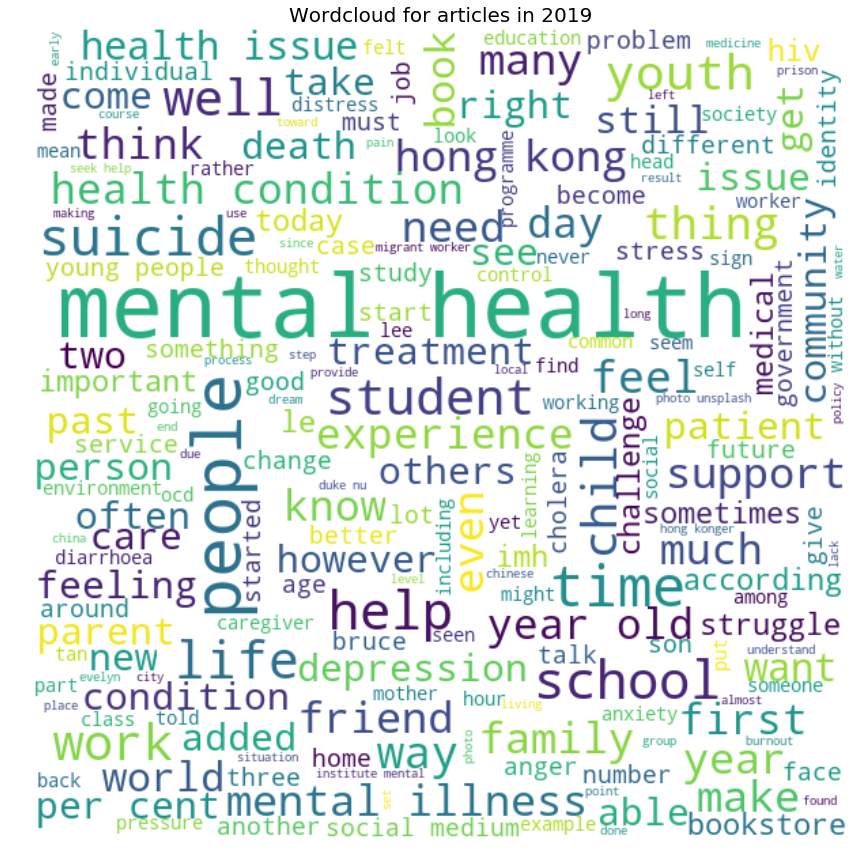

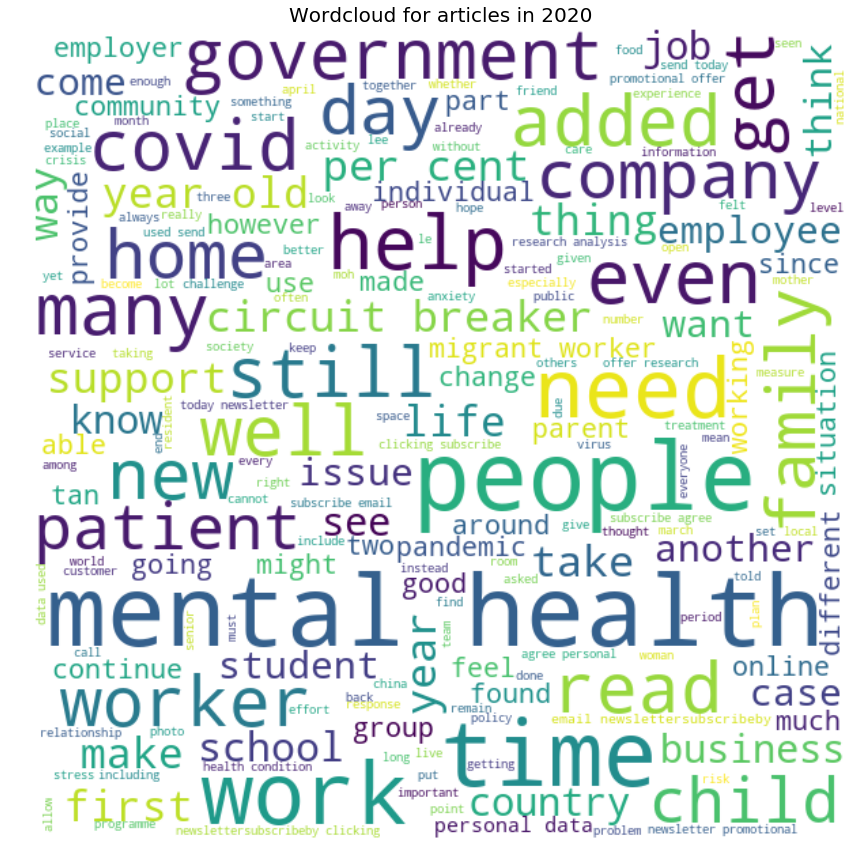

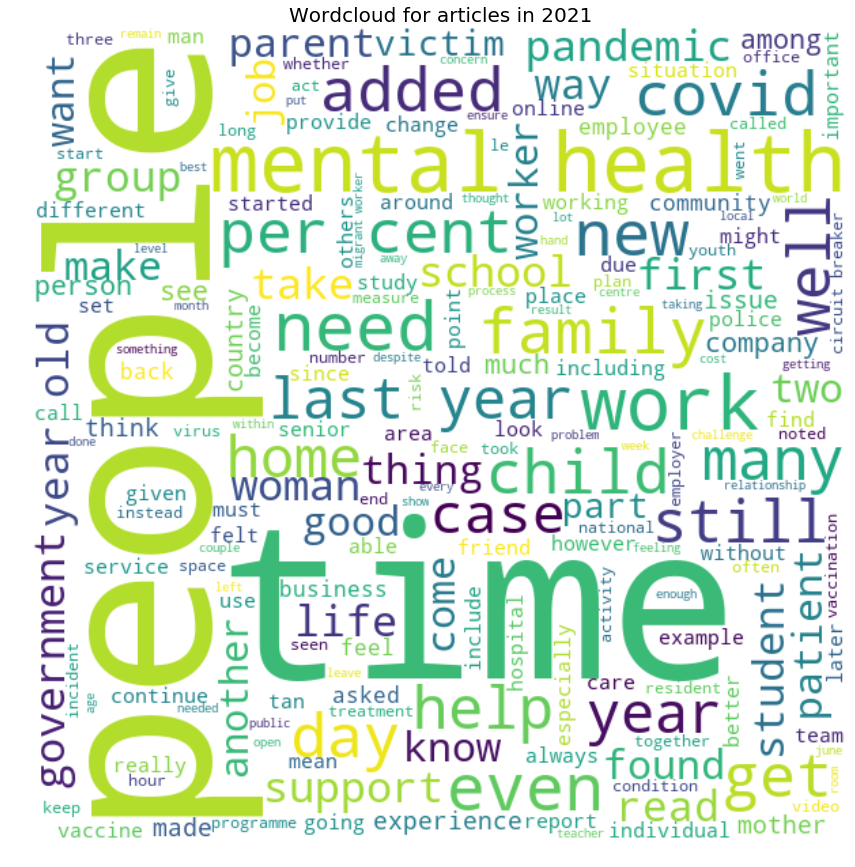

In [9]:
# filter articles by year (contributed by Shaun and Samson)
articles_2019 = df[(df.date >= parser.parse("01 Jan 2019")) & (df.date <= parser.parse("31 Dec 2019"))]
articles_2020 = df[(df.date >= parser.parse("01 Jan 2020")) & (df.date <= parser.parse("31 Dec 2020"))]
articles_2021 = df[(df.date >= parser.parse("01 Jan 2021")) & (df.date <= parser.parse("31 Dec 2021"))]


def create_wordcloud(text_series, title):
    
    wc = WordCloud(background_color = 'white', stopwords=nltk_stopwords, height = 600, width = 600)
    words = ' '.join(w for w in text_series)
    wc.generate(words)

    plt.figure(figsize=(15,15))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize= 20)
    plt.axis('off')
    plt.show()

create_wordcloud(articles_2019['cleaned_content'], 'Wordcloud for articles in 2019')
create_wordcloud(articles_2020['cleaned_content'], 'Wordcloud for articles in 2020')
create_wordcloud(articles_2021['cleaned_content'], 'Wordcloud for articles in 2021') 

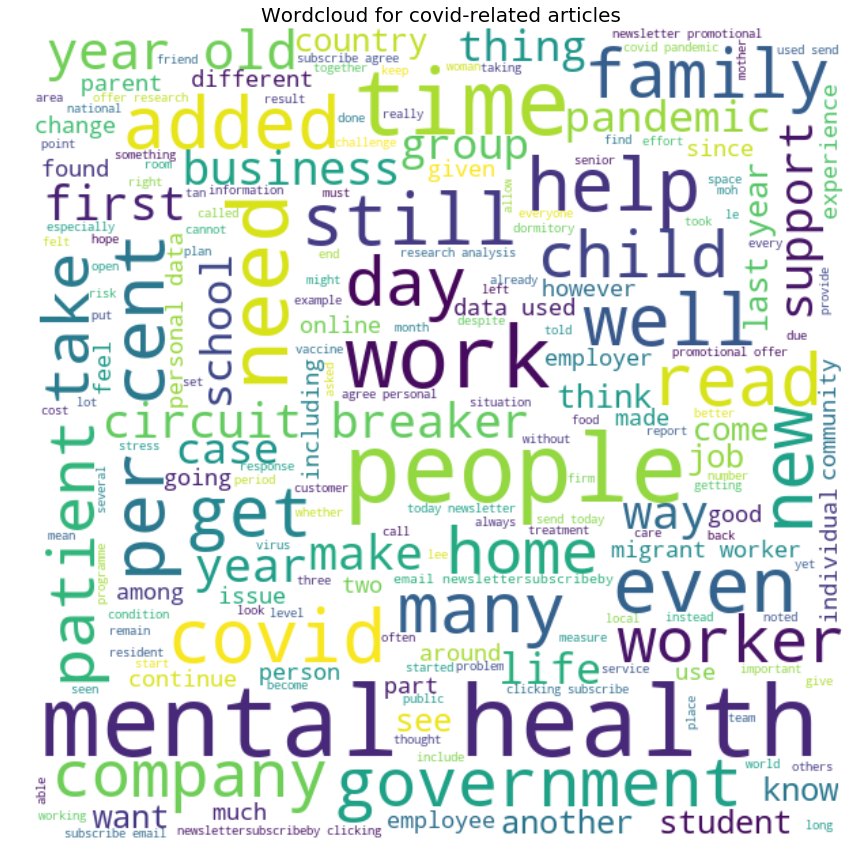

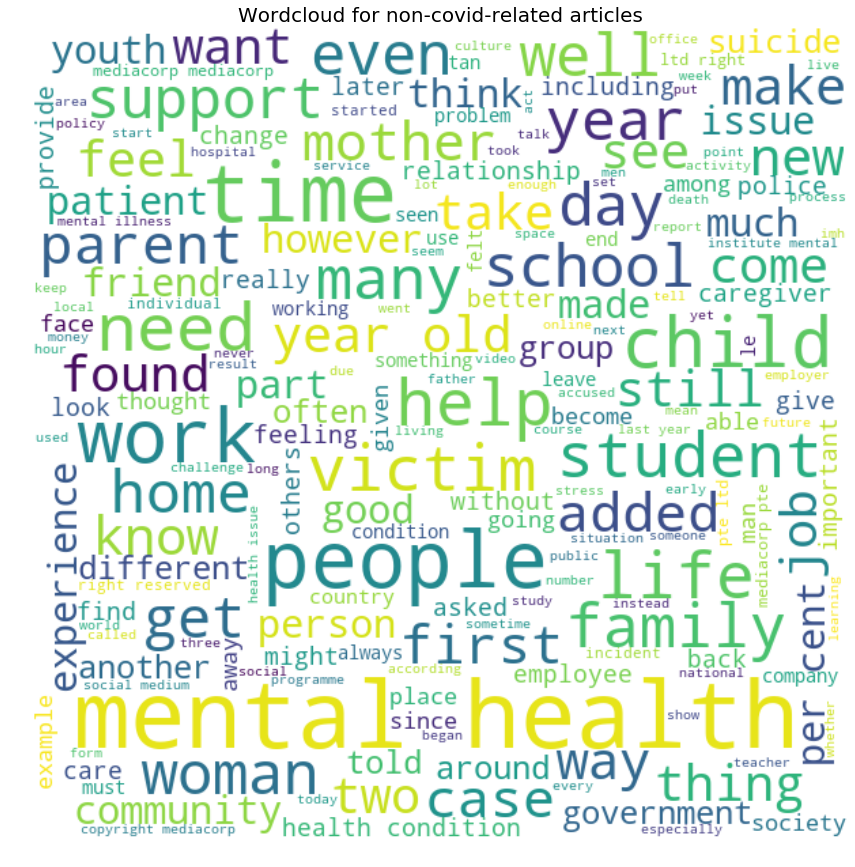

In [10]:
covid_articles = df[df['covid']]
non_covid_articles = df[~df['covid']]
create_wordcloud(covid_articles['cleaned_content'], 'Wordcloud for covid-related articles')
create_wordcloud(non_covid_articles['cleaned_content'], 'Wordcloud for non-covid-related articles')

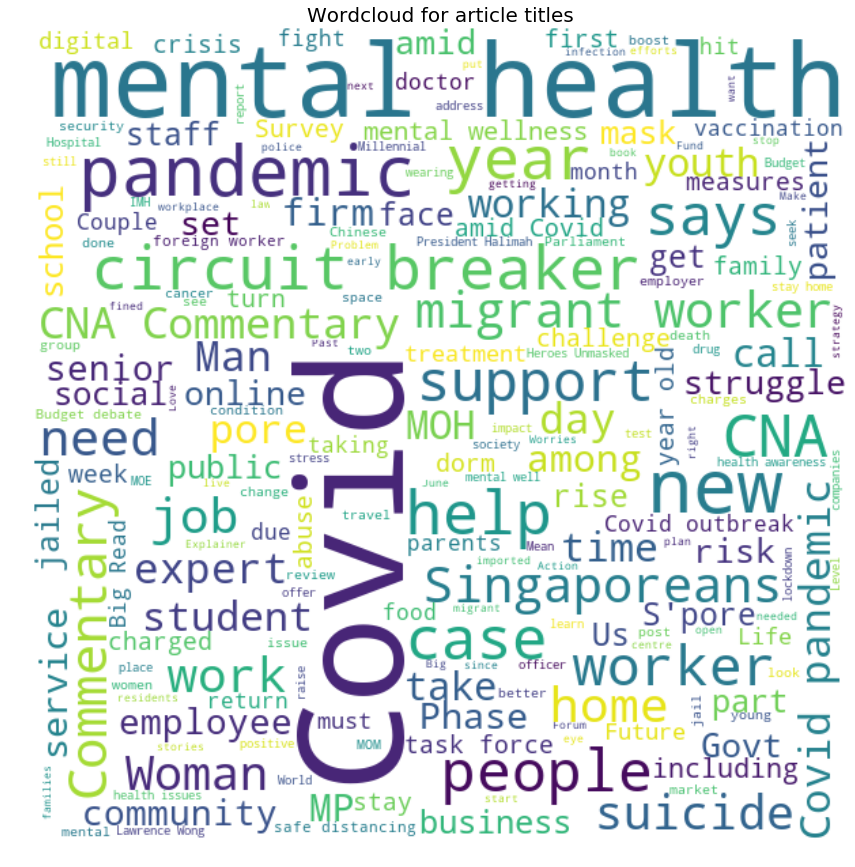

In [11]:
create_wordcloud(covid_articles['title'], 'Wordcloud for article titles')

## Topic Modelling (using LDA)
(contributed by Yu Xiang)

In [12]:
#LDA viz for topic modelling
def lda_viz(df_series, num_topics):
    corpus = df_series.apply(lambda x: x.split()) # corpus is a list of list of words
    
    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = num_topics, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    print(lda_model.show_topics())
    pyLDAvis.enable_notebook()
    viz = gensimvis.prepare(lda_model, bow_corpus, dic)
    return viz

In [13]:
##LDA for (processed) titles of articles
viz_title = lda_viz(df["title"].apply(text_processor), num_topics=4)
viz_title

[(0, '0.016*"mental" + 0.013*"health" + 0.009*"people" + 0.006*"cna" + 0.006*"commentary" + 0.005*"life" + 0.005*"new" + 0.005*"family" + 0.005*"breaker" + 0.005*"circuit"'), (1, '0.033*"covid" + 0.016*"worker" + 0.010*"mental" + 0.008*"woman" + 0.008*"migrant" + 0.007*"health" + 0.007*"pandemic" + 0.007*"new" + 0.006*"help" + 0.005*"cna"'), (2, '0.032*"covid" + 0.022*"mental" + 0.016*"health" + 0.013*"cna" + 0.009*"commentary" + 0.008*"new" + 0.007*"case" + 0.005*"pore" + 0.004*"worker" + 0.004*"singaporean"'), (3, '0.017*"mental" + 0.015*"health" + 0.014*"covid" + 0.014*"cna" + 0.012*"commentary" + 0.011*"pandemic" + 0.011*"year" + 0.008*"man" + 0.007*"support" + 0.006*"suicide"')]


C:\Users\hengs\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.082125  0.010750       1        1  28.139775
2      0.017887 -0.095396       2        1  26.912965
3      0.010290  0.084252       3        1  25.913820
0     -0.110302  0.000394       4        1  19.033440, topic_info=             Term        Freq       Total Category  logprob  loglift
154         covid  198.000000  198.000000  Default  30.0000  30.0000
96         worker   60.000000   60.000000  Default  29.0000  29.0000
207        people   27.000000   27.000000  Default  28.0000  28.0000
158      pandemic   46.000000   46.000000  Default  27.0000  27.0000
171       migrant   25.000000   25.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
191           man    5.275005   35.257129   Topic4  -5.7791  -0.2407
1075       police    3.902983   11.108789   Topic4  -6.0804   0.6130
98    singaporean    4.411366   18.615062   Topic4  -5.9579   0.2192
84           work    4.434166   20.992249   Topic4  -5.9528   0.1042
154         covid    5.961401  198.063273   Topic4  -5.6568  -1.8443

[300 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1699      1  0.907226  abuse
841       4  0.698562  agent
203       4  0.839276  alone
883       1  0.264043   amid
883       2  0.422469   amid
...     ...       ...    ...
85        1  0.788592   yong
789       1  0.183273  youth
789       2  0.274909  youth
789       3  0.412364  youth
789       4  0.091636  youth

[447 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [14]:
viz_content = lda_viz(df["cleaned_content"], num_topics=4)
viz_content

[(0, '0.007*"worker" + 0.006*"work" + 0.006*"covid" + 0.006*"time" + 0.006*"year" + 0.005*"home" + 0.005*"people" + 0.004*"school" + 0.004*"child" + 0.004*"per"'), (1, '0.007*"year" + 0.005*"police" + 0.004*"time" + 0.004*"victim" + 0.004*"people" + 0.003*"woman" + 0.003*"two" + 0.003*"court" + 0.003*"home" + 0.003*"man"'), (2, '0.020*"mental" + 0.018*"health" + 0.008*"people" + 0.006*"year" + 0.005*"help" + 0.005*"work" + 0.005*"time" + 0.004*"support" + 0.004*"life" + 0.004*"condition"'), (3, '0.007*"covid" + 0.006*"year" + 0.005*"people" + 0.005*"case" + 0.004*"read" + 0.004*"time" + 0.004*"home" + 0.004*"day" + 0.004*"need" + 0.003*"family"')]


C:\Users\hengs\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.033679  0.029177       1        1  29.866000
3     -0.007052  0.060587       2        1  26.656788
2      0.073841 -0.054925       3        1  25.465382
1     -0.100468 -0.034840       4        1  18.011831, topic_info=         Term         Freq        Total Category  logprob  loglift
421    mental  3514.000000  3514.000000  Default  30.0000  30.0000
371    health  3718.000000  3718.000000  Default  29.0000  29.0000
725    police   585.000000   585.000000  Default  28.0000  28.0000
10189  victim   452.000000   452.000000  Default  27.0000  27.0000
1323   worker  2098.000000  2098.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
284      case   234.368973  1594.805161   Topic4  -6.1356  -0.2035
315       day   234.718746  1773.038603   Topic4  -6.1342  -0.3079
76       even   225.842049  1503.094295   Topic4  -6.1727  -0.1813
350    family   213.007036  1802.806268   Topic4  -6.2312  -0.4216
669      take   200.363437  1264.908043   Topic4  -6.2924  -0.1285

[395 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9492      1  0.014470  accused
9492      2  0.014470  accused
9492      3  0.072348  accused
9492      4  0.904352  accused
693       1  0.091514      act
...     ...       ...      ...
692       4  0.124482    young
2028      1  0.145412    youth
2028      2  0.089861    youth
2028      3  0.707455    youth
2028      4  0.055551    youth

[894 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])